# 2023年度 深層学習演習 最終課題
## 23vr008n 高林 秀

## 問題設定
### 選択した課題
* (a) : テーブルデータ、画像データ、系列データのいずれか(※ 広い意味で捉えて良い) を用意し、回帰もしくは分類タスクを設定して深層学習モデルにより学習、評価を行え。よりよい結果が得られるよう試行錯誤し、過程も含めて示すこと。 
### 設定したタスク
* ポケモンの画像分類-オーキドモデルを作る-
 * 下記データセットを使用する。
 * 149クラスある
* https://www.kaggle.com/datasets/echometerhhwl/pokemon-gen-1-38914

## データセットについて
学習で使うデータセットはkaggleからダウンロードしたものを使用する。

このデータは、**149種類のポケモンの画像**が入っている。アニメ画像の切り抜きや、手書きで描いたポケモンの画像などが含まれている。

各ポケモン毎にフォルダが分かれており、その中に画像が入っている。
画像の層数は全部で**35627枚**である。

## 使用するモデルについて
本課題では事前学習済みのモデルをファインチューニングすることで、オーキドモデルを作成する。

今回使用するモデルは以下の通りである。
* モデル名：VGG16
* TODO: モデルの説明を書く

## 評価方法
ダウンロードしたデータセットを、学習用とテストセットに分け、テストセットを用いて評価を行う。

なお、評価方法は、**Accuracy**を用いる。

## 実行環境
本稿で作成したモデルは、ローカルマシン上で構築した。以下に実行環境を示す。

* OS: Windows 11
* CPU: Intel(R) Core(TM) i7-13700H @ 2.40GHz
* GPU: NVIDIA GeForce RTX 4060 Laptop GPU @ 8GB
* RAM: 32GB
* 開発環境
    * Python 3.9.6
    * PyTorch 1.9.1 + cu111
    * Torchvision 0.10.1 + cu111

## サンプルデータの表示
学習データで使用する画像は次のようなもので、単純にポケモンのみが写っているものもあれば、背景に人間が写っているものや、手書きのもの、カード状のものまで様々である。

<img src="archive/data/Raichu/0c7e0a91bf65facbbc2d2c06b55f1bf2.jpg" style="width: 250px;"/>
<img src="archive/data/Raichu/ee730b7e1e47a1aafd94476016875344.jpg" style="width: 250px;"/>
<img src="archive/data/Vileplume/0ac8fd551dd66cda9f03e6124363b071.png" style="width: 250px;"/>
<img src="archive/data/Zapdos/0b3cf9fd603a437e50e76222ce0db245.jpg" style="width: 250px;"/>


## 実装/モデル構築

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from torch.utils.data import random_split
import torch.nn as nn
import torchvision.models as models
import pandas as pd


C:\Users\syu\AppData\Local\Temp\ipykernel_33352\3691634451.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#CUDAが有効化どうかの確認
print(f"CUDA is Available : {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


CUDA is Available : True


In [3]:
DATA_DIR = "archive/data"

# 画像の前処理（リサイズ、テンソル変換など）
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

#各画像が格納されたサブディレクトリの名前をクラス名として扱う。
all_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform) 
all_data_loader = DataLoader(all_dataset, batch_size=1, shuffle=True, pin_memory=True)

print(f"Class = {all_dataset.classes}")
print(f"Class Size = {len(all_dataset.classes)}")

CLASS_SIZE = len(all_dataset.classes)

Class = ['Abra', 'Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Nidoqueen', 'N

### データサンプルの提示
実際に学習、評価に使用するデータのサンプルを提示する。

以下は、データセットから最初の９枚を選んだ画像である。

以下のように、様々なタッチの画像が含まれていて、中にはカードのようなものも含まれている。

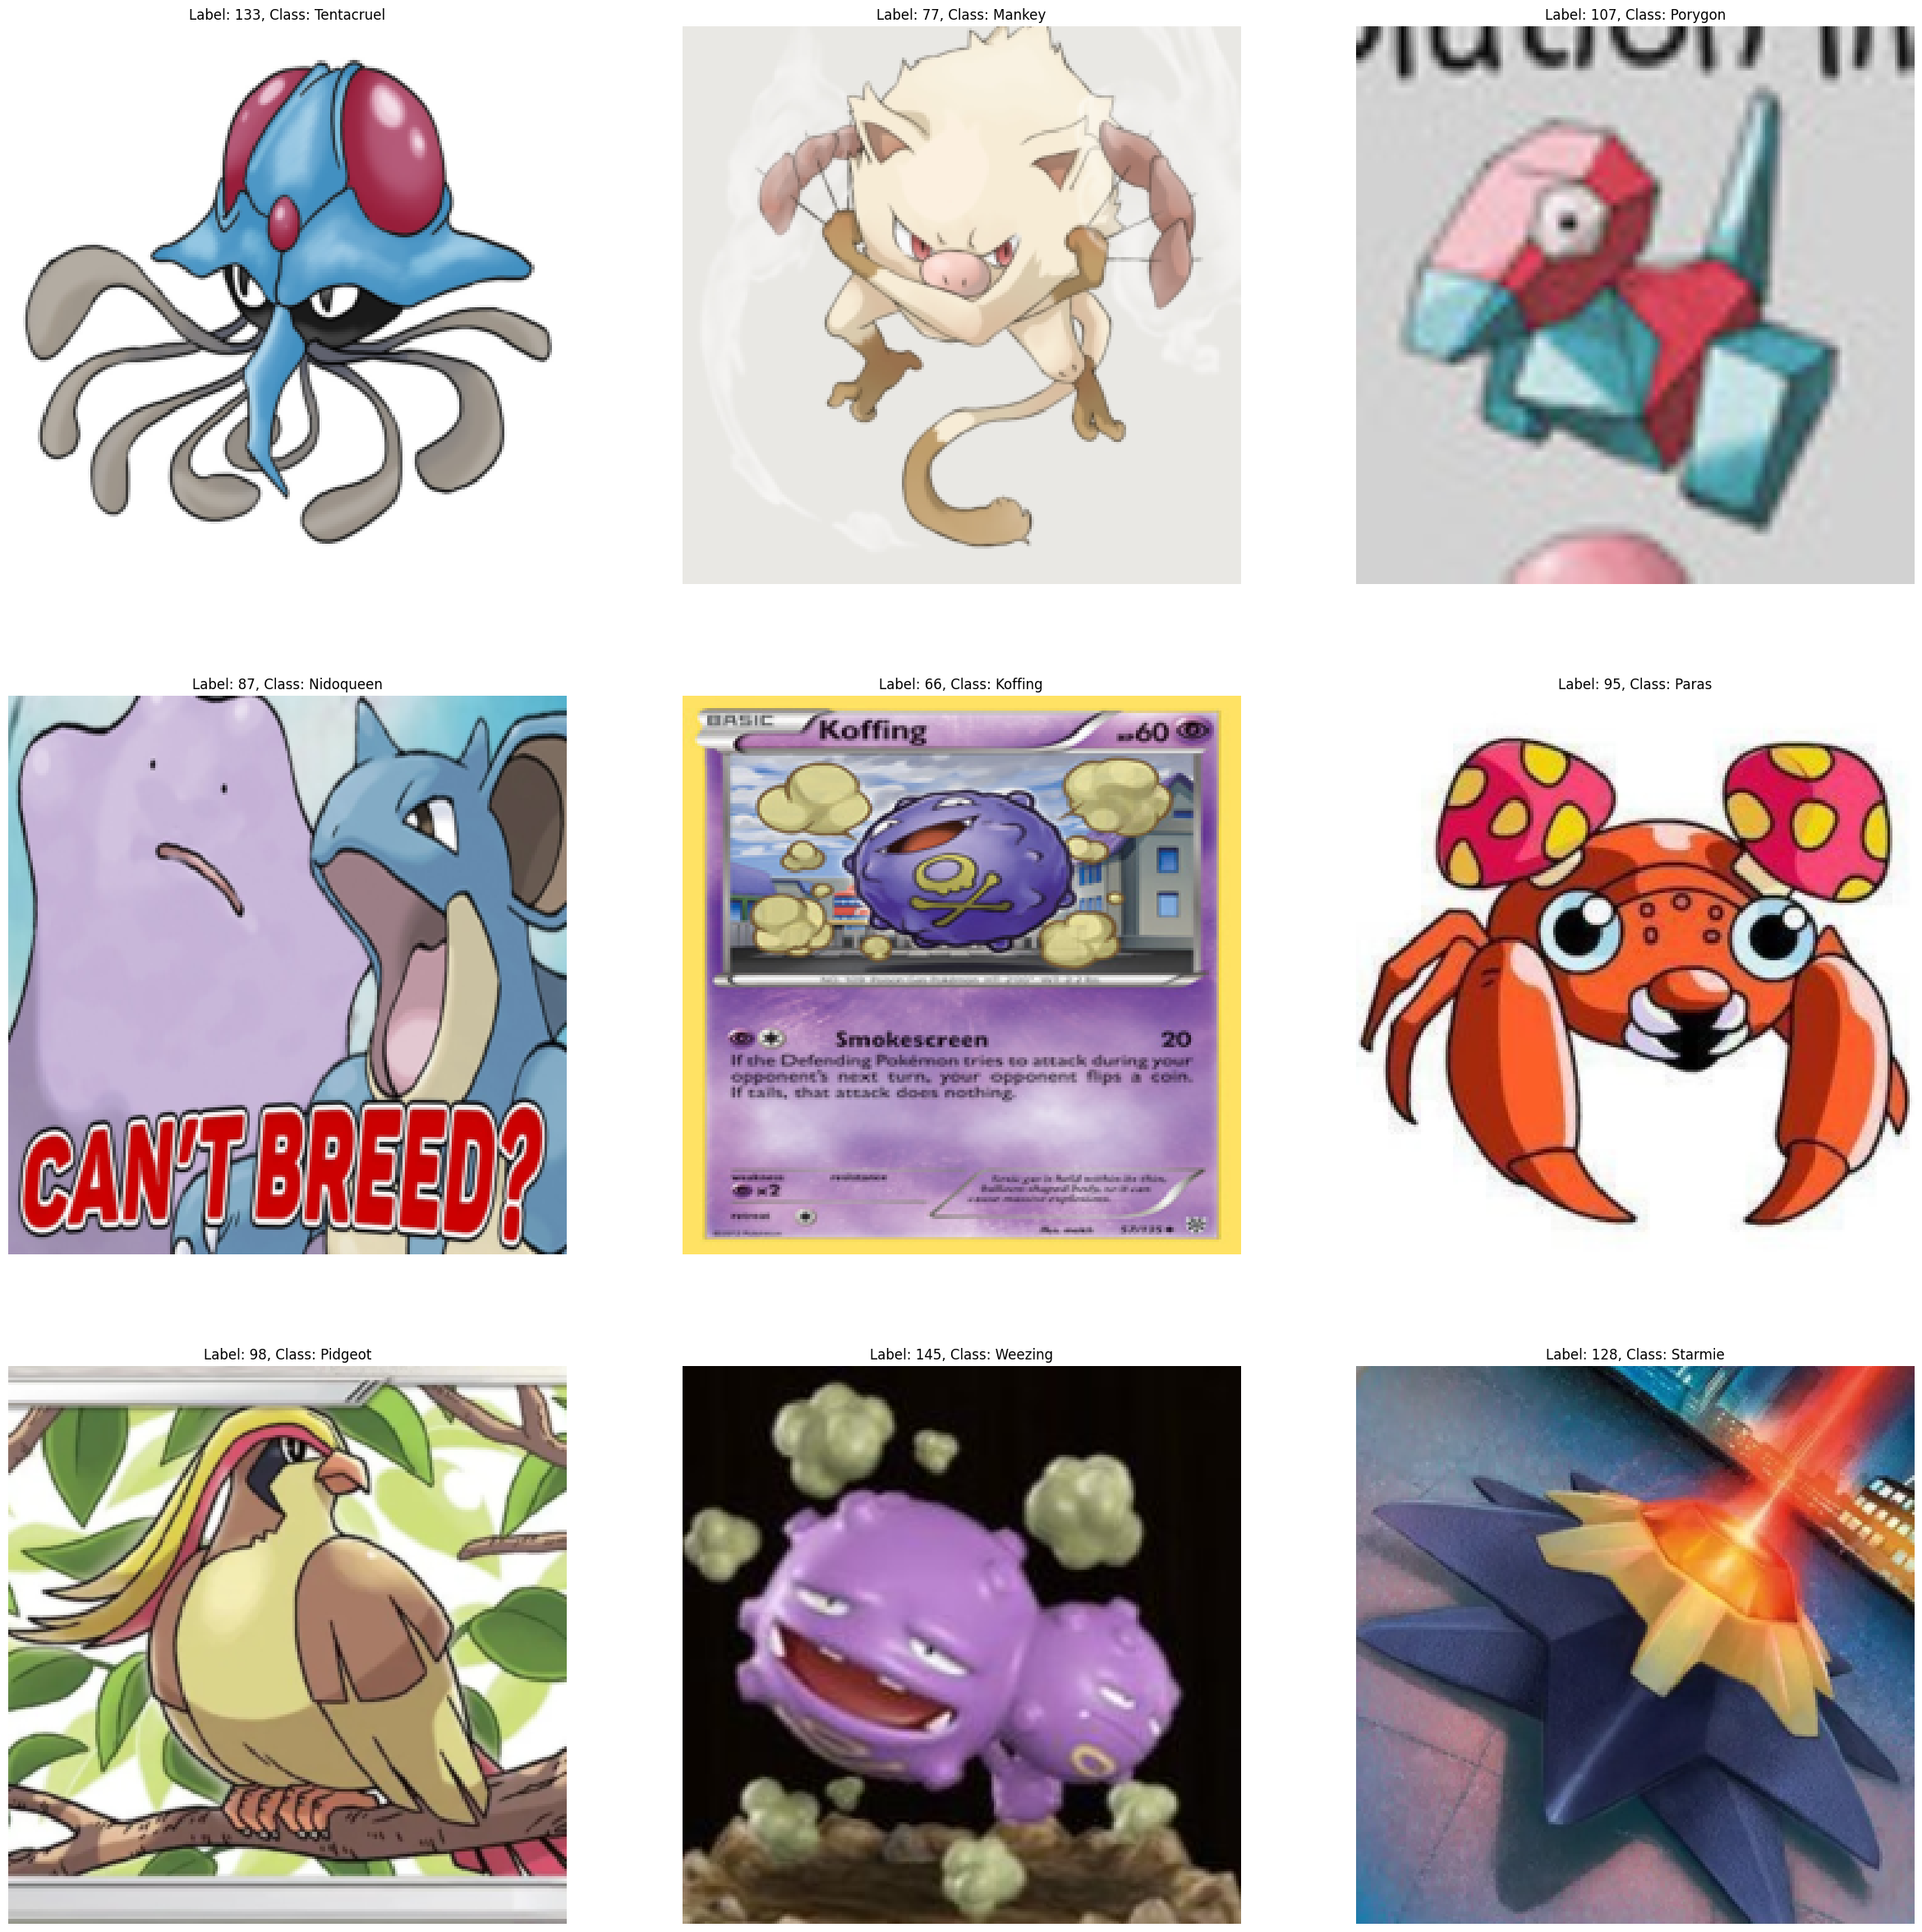

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(30, 30))
for i, (images, labels) in enumerate(all_data_loader):
    if i < 9:  # 最初の9枚の画像のみ表示
        img = images[0]
        label = labels[0].item()
        class_name = all_dataset.classes[label]
        ax = axs[i // 3, i % 3]
        ax.imshow(img.permute(1, 2, 0))  # チャンネル次元の順序を変更
        ax.set_title(f'Label: {label}, Class: {class_name}')
        ax.axis('off')
    else:
        break

plt.show()

### データの分割：学習データ（訓練 & 検証用）とテスト（評価用）データに分ける。

In [5]:
total_size = len(all_dataset)
train_size = int(total_size * 0.8)  # 80%を学習用データに
test_size = total_size - train_size  # 残り20%をテスト用データに

# データセットをランダムに分割
train_dataset, test_dataset = random_split(all_dataset, [train_size, test_size])

# DataLoaderを作成
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=True)

### データ分布の確認

ヒストグラムを表示し、学習データのラベル分布を確認する。

Generating Distribution...:   2%|▏         | 526/28500 [00:03<03:36, 128.92it/s]c:\Users\syu\Learning\Class_DL-Exercises\.venv\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Generating Distribution...: 100%|██████████| 28500/28500 [02:56<00:00, 161.06it/s]


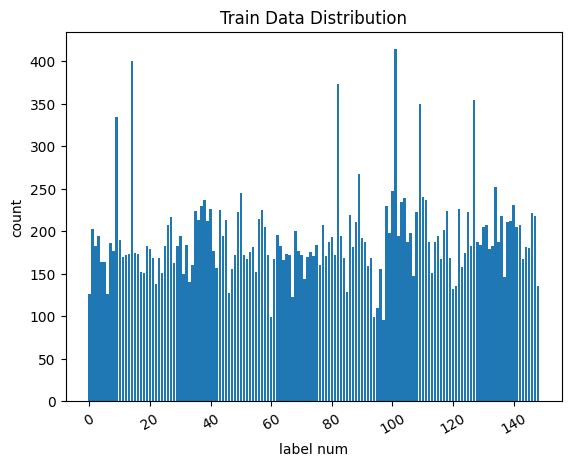

[126,
 203,
 183,
 195,
 164,
 164,
 126,
 186,
 177,
 334,
 190,
 170,
 172,
 173,
 400,
 174,
 173,
 152,
 151,
 183,
 179,
 169,
 138,
 169,
 151,
 183,
 207,
 217,
 163,
 183,
 195,
 150,
 184,
 140,
 161,
 224,
 213,
 230,
 237,
 212,
 226,
 177,
 157,
 225,
 194,
 213,
 128,
 156,
 172,
 223,
 245,
 172,
 168,
 176,
 182,
 152,
 215,
 225,
 205,
 172,
 99,
 168,
 196,
 183,
 166,
 173,
 172,
 123,
 201,
 177,
 172,
 144,
 170,
 176,
 171,
 184,
 160,
 207,
 171,
 188,
 193,
 172,
 373,
 195,
 169,
 129,
 219,
 182,
 211,
 268,
 192,
 188,
 159,
 169,
 99,
 110,
 156,
 96,
 230,
 198,
 248,
 414,
 195,
 235,
 239,
 188,
 198,
 147,
 223,
 350,
 240,
 237,
 187,
 151,
 187,
 195,
 168,
 202,
 224,
 169,
 132,
 136,
 226,
 158,
 175,
 223,
 183,
 355,
 188,
 184,
 205,
 207,
 179,
 183,
 252,
 187,
 218,
 146,
 211,
 212,
 231,
 205,
 208,
 168,
 182,
 180,
 222,
 218,
 136]

In [6]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True #NOTE:調べたところtorchで読み込むとPILの画像破損判定に引っかかる。強制的に読み込む。
def show_distribution(loader, title="") -> list[int]:
    count = [0] * CLASS_SIZE
    for _, label in tqdm(loader, desc="Generating Distribution..."):
        for l in label:
            count[l] += 1
    plt.bar(range(CLASS_SIZE), count)
    plt.xticks(rotation=30)
    plt.xlabel("label num")
    plt.ylabel("count")
    plt.title(title)
    plt.show()
    return count

show_distribution(train_loader, "Train Data Distribution")

上記分布より学習データにはある程度ラベルの偏りがあることがわかる。

モデルが偏ることを防ぐため、訓練データのダウンサンプリングを行った上で学習させてみる。※テストデータはそのまま

In [7]:
#ダウンサンプリング

class BalancedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indices = self.balance_classes()

    def balance_classes(self):
        # 各クラスのインデックスを格納する
        class_indices = defaultdict(list)
        for idx, (_, label) in tqdm(enumerate(self.dataset), desc="Collectioning Index..."):
            class_indices[label].append(idx)

        min_size = min(len(indices) for indices in class_indices.values())

        # 各クラスからランダムにmin_size個のインデックスを選択
        balanced_indices = []
        for indices in tqdm(class_indices.values(), desc="Down Sampling..."):
            balanced_indices.extend(np.random.choice(indices, min_size, replace=False))

        return balanced_indices

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)
    
d_sampled_dataset = BalancedDataset(train_dataset)
print(f"down sampled_dataset size = {len(d_sampled_dataset)}")


Collectioning Index...: 28500it [02:46, 171.38it/s]
Down Sampling...: 100%|██████████| 149/149 [00:00<00:00, 29652.27it/s]

down sampled_dataset size = 14304


split_size =[11443, 2861]


Generating Distribution...: 100%|██████████| 358/358 [01:07<00:00,  5.29it/s]


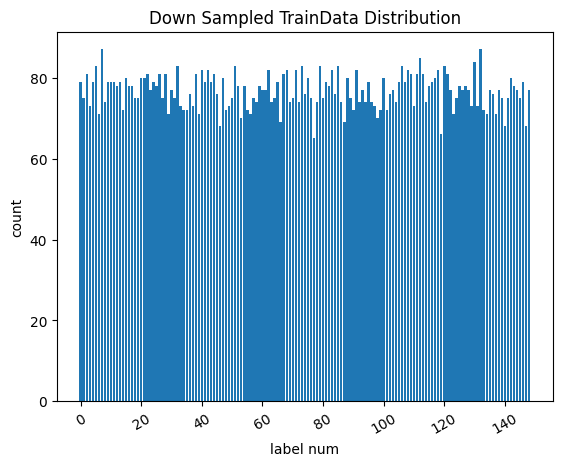

Generating Distribution...: 100%|██████████| 90/90 [00:16<00:00,  5.55it/s]


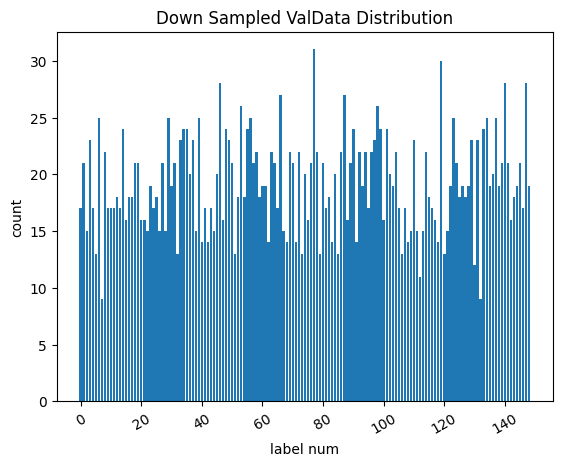

In [8]:
#ローダーの再定義

TRAIN_RATO = 0.8

train_size = int(len(d_sampled_dataset) * TRAIN_RATO)
val_size = len(d_sampled_dataset) - train_size
split_size = [train_size, val_size]
print(f"split_size ={split_size}")

d_sampled_train_dataset, d_sampled_val_dataset = random_split(d_sampled_dataset, split_size)

d_sampled_train_loader = DataLoader(d_sampled_train_dataset, batch_size=32, shuffle=True)
d_sampled_val_loader = DataLoader(d_sampled_val_dataset, batch_size=32, shuffle=False)

d_sampled_train_dist = show_distribution(d_sampled_train_loader, "Down Sampled TrainData Distribution")
d_sampled_val_dist = show_distribution(d_sampled_val_loader, "Down Sampled ValData Distribution")


In [9]:
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


def plot_learning_curves(train_losses, val_accuracies):
    """学習曲線（損失と精度）をプロットする関数"""
    plt.figure(figsize=(12, 6))
    
    # 訓練損失のプロット
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 検証精度のプロット
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



In [10]:
learning_rates = [0.001, 0.0001]
EPOCH = 10

best_accuracy = 0
best_history = None

for lr in learning_rates:
    
    print(f"Training with LR={lr},")

    # モデルの準備
    model = models.vgg16(pretrained=True)
    model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, CLASS_SIZE)
    model = model.to(device)

    # 損失関数とオプティマイザー
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 訓練と検証の履歴を保存するリスト
    train_losses = []
    val_accuracies = []

    # 訓練ループ
    for epoch in range(EPOCH):
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(d_sampled_train_loader, desc="training..."):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(d_sampled_train_loader)
        train_losses.append(avg_train_loss)

        accuracy = calculate_accuracy(model, d_sampled_val_loader)
        val_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}: Loss = {avg_train_loss:.4f}, Accuracy = {accuracy:.4f}%")

        # 最良のモデルを更新
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_history = {
                "train_losses": train_losses,
                "val_accuracies": val_accuracies,
                "lr": lr,
            }
            torch.save(model.state_dict(), "best_model.pth")


Training with LR=0.001,


training...: 100%|██████████| 358/358 [04:23<00:00,  1.36it/s]


Epoch 1: Loss = 5.0223, Accuracy = 0.3146%


training...: 100%|██████████| 358/358 [04:42<00:00,  1.27it/s]


Epoch 2: Loss = 5.0099, Accuracy = 0.5592%


training...: 100%|██████████| 358/358 [04:38<00:00,  1.28it/s]


Epoch 3: Loss = 5.0095, Accuracy = 0.4194%


training...: 100%|██████████| 358/358 [04:36<00:00,  1.29it/s]


Epoch 4: Loss = 5.0086, Accuracy = 0.4544%


training...: 100%|██████████| 358/358 [04:48<00:00,  1.24it/s]


Epoch 5: Loss = 5.0076, Accuracy = 0.4893%


training...: 100%|██████████| 358/358 [04:46<00:00,  1.25it/s]


Epoch 6: Loss = 5.0072, Accuracy = 0.4544%


training...: 100%|██████████| 358/358 [04:46<00:00,  1.25it/s]


Epoch 7: Loss = 5.0061, Accuracy = 0.3146%


training...: 100%|██████████| 358/358 [04:46<00:00,  1.25it/s]


Epoch 8: Loss = 5.0068, Accuracy = 0.5243%


training...: 100%|██████████| 358/358 [04:47<00:00,  1.24it/s]


Epoch 9: Loss = 5.0064, Accuracy = 0.3146%


training...: 100%|██████████| 358/358 [04:41<00:00,  1.27it/s]


Epoch 10: Loss = 5.0056, Accuracy = 0.3845%
Training with LR=0.0001,


training...: 100%|██████████| 358/358 [04:50<00:00,  1.23it/s]


Epoch 1: Loss = 3.6652, Accuracy = 57.9168%


training...: 100%|██████████| 358/358 [04:47<00:00,  1.25it/s]


Epoch 2: Loss = 1.2148, Accuracy = 75.9874%


training...: 100%|██████████| 358/358 [04:48<00:00,  1.24it/s]


Epoch 3: Loss = 0.5334, Accuracy = 82.0343%


training...: 100%|██████████| 358/358 [04:45<00:00,  1.25it/s]


Epoch 4: Loss = 0.3042, Accuracy = 83.6071%


training...: 100%|██████████| 358/358 [04:46<00:00,  1.25it/s]


Epoch 5: Loss = 0.2157, Accuracy = 83.4324%


training...: 100%|██████████| 358/358 [04:48<00:00,  1.24it/s]


Epoch 6: Loss = 0.1529, Accuracy = 80.7760%


training...: 100%|██████████| 358/358 [04:47<00:00,  1.24it/s]


Epoch 7: Loss = 0.1346, Accuracy = 83.8168%


training...: 100%|██████████| 358/358 [04:47<00:00,  1.24it/s]


Epoch 8: Loss = 0.1081, Accuracy = 82.4886%


training...: 100%|██████████| 358/358 [04:43<00:00,  1.26it/s]


Epoch 9: Loss = 0.0795, Accuracy = 81.7546%


training...: 100%|██████████| 358/358 [04:43<00:00,  1.26it/s]


Epoch 10: Loss = 0.0940, Accuracy = 82.6634%


Best model with LR=0.0001, Accuracy=83.8168%


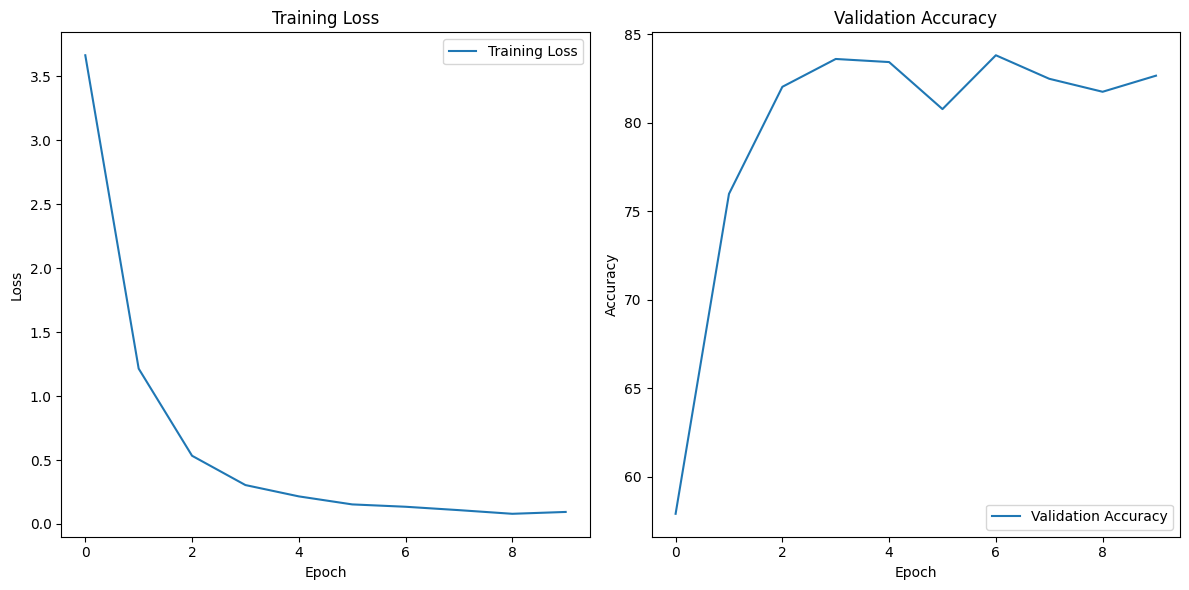

<All keys matched successfully>

In [15]:
# 最良のモデルの学習曲線をプロット
if best_history:
    print(f"Best model with LR={best_history['lr']}, Accuracy={best_accuracy:.4f}%")
    plot_learning_curves(best_history["train_losses"], best_history["val_accuracies"])

#保存したモデルの読み込み
model.load_state_dict(torch.load("./best_model.pth"))

Testing...:  15%|█▌        | 1091/7126 [00:17<01:35, 63.22it/s]c:\Users\syu\Learning\Class_DL-Exercises\.venv\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Testing...: 100%|██████████| 7126/7126 [02:24<00:00, 49.42it/s]


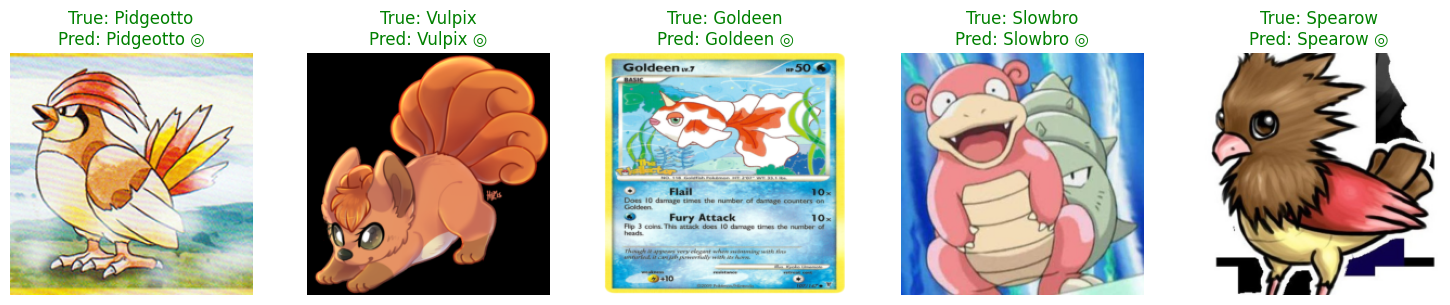

In [16]:
all_images = []
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing...",):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_images.extend(images.cpu())
        all_labels.extend(labels.cpu())
        all_preds.extend(preds.cpu())

# テスト結果の一部を表示
# ランダムに5件を選択
indices = np.random.choice(len(all_images), size=5, replace=False)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))  # 5枚の画像を横に並べる

for ax, i in zip(axes, indices):
    img = all_images[i].cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    true_label = all_dataset.classes[all_labels[i]]
    pred_label = all_dataset.classes[all_preds[i]]
    correct = "◎" if all_labels[i] == all_preds[i] else "✖"
    color = "green" if correct == "◎" else "red"
    
    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {pred_label} {correct}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()





In [17]:
# DataFrameに格納するためのインデックスリストを作成
image_indices = list(range(len(all_images)))

# 正誤を判定
results = ["◎" if lbl == pred else "✖" for lbl, pred in zip(all_labels, all_preds)]

# 表形式で情報をまとめる
df = pd.DataFrame({
    "正解ラベル": [all_dataset.classes[lbl] for lbl in all_labels],
    "予測ラベル": [all_dataset.classes[pred] for pred in all_preds],
    "正誤": results,
    "入力画像": image_indices
})

df

,正解ラベル,予測ラベル,正誤,入力画像
0,Ponyta,Ponyta,◎,0
1,Hitmonlee,Hitmonlee,◎,1
2,Dragonair,Dewgong,✖,2
3,Bellsprout,Bellsprout,◎,3
4,Magneton,Magneton,◎,4
...,...,...,...,...
7121,Psyduck,Psyduck,◎,7121
7122,Weezing,Muk,✖,7122
7123,Geodude,Geodude,◎,7123
7124,Scyther,Scyther,◎,7124


Test Accuracy = 0.8329


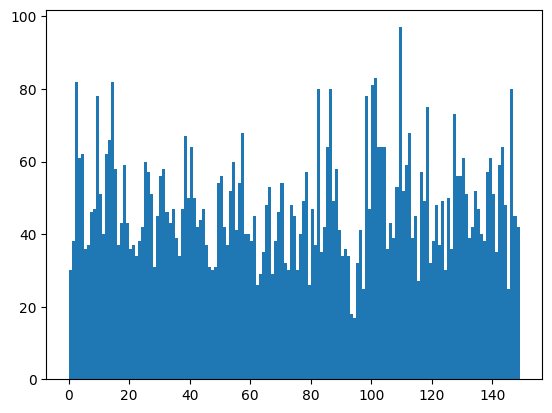

In [20]:
import numpy as np
# Convert boolean array to numpy array
all_labels_np = np.array(all_labels)
all_preds_np = np.array(all_preds)

# モデルの予測ラベルの分布
plt.hist(all_preds_np, bins=range(CLASS_SIZE+1))

# テスト精度の表示
accuracy = (all_labels_np == all_preds_np).sum() / len(all_labels_np)
print(f"Test Accuracy = {accuracy:.4f}")

### 上手く判定できなかった画像を考察してみる